In [14]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
pd.options.display.float_format = '{:.6f}'.format

In [36]:
df = pd.read_csv('../data/overall_stats_for_ps4.csv', index_col=0)
df = df.fillna(0)
print "{} rows".format(df.shape[0])
print "{} columns".format(df.shape[1])
df.head(1).T

133524 rows
20 columns


,25625
stats.overall.assists,1232.000000
stats.overall.barricades_built,2155.000000
stats.overall.bullets_fired,163842.000000
stats.overall.bullets_hit,43493.000000
stats.overall.headshots,1823.000000
stats.overall.melee_kills,55.000000
stats.overall.penetration_kills,525.000000
stats.overall.reinforcements_deployed,6131.000000
stats.overall.revives,165.000000
stats.overall.steps_moved,1136840.000000


In [37]:
from sklearn.decomposition import pca
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [38]:
scaler = MinMaxScaler(feature_range=(0,1), copy=True).fit(df)
# scaler = StandardScaler(copy=True).fit(df)

X_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

reducer = pca.PCA(n_components=2, whiten=True).fit(X_scaled)
X_pca = pd.DataFrame(reducer.transform(X_scaled), index=df.index, columns=['pca1', 'pca2'])
X_pca.head()

,pca1,pca2
25625,0.712363,-1.138705
19782,-0.212624,0.918993
358815,5.947542,0.818812
610174,-1.021002,0.419218
86495,-0.475232,-0.455424


In [39]:
X = X_pca.copy().sample(n=10000).values
X

array([[-0.98662834,  0.14374067],
       [ 0.11008136, -0.82781815],
       [ 1.55693465, -2.15154566],
       ..., 
       [-0.68529178, -0.37173437],
       [-0.75310226,  0.08508843],
       [ 3.70263364, -1.99562367]])

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

('For n_clusters =', 2, 'The average silhouette_score is :', 0.45747244825461114)


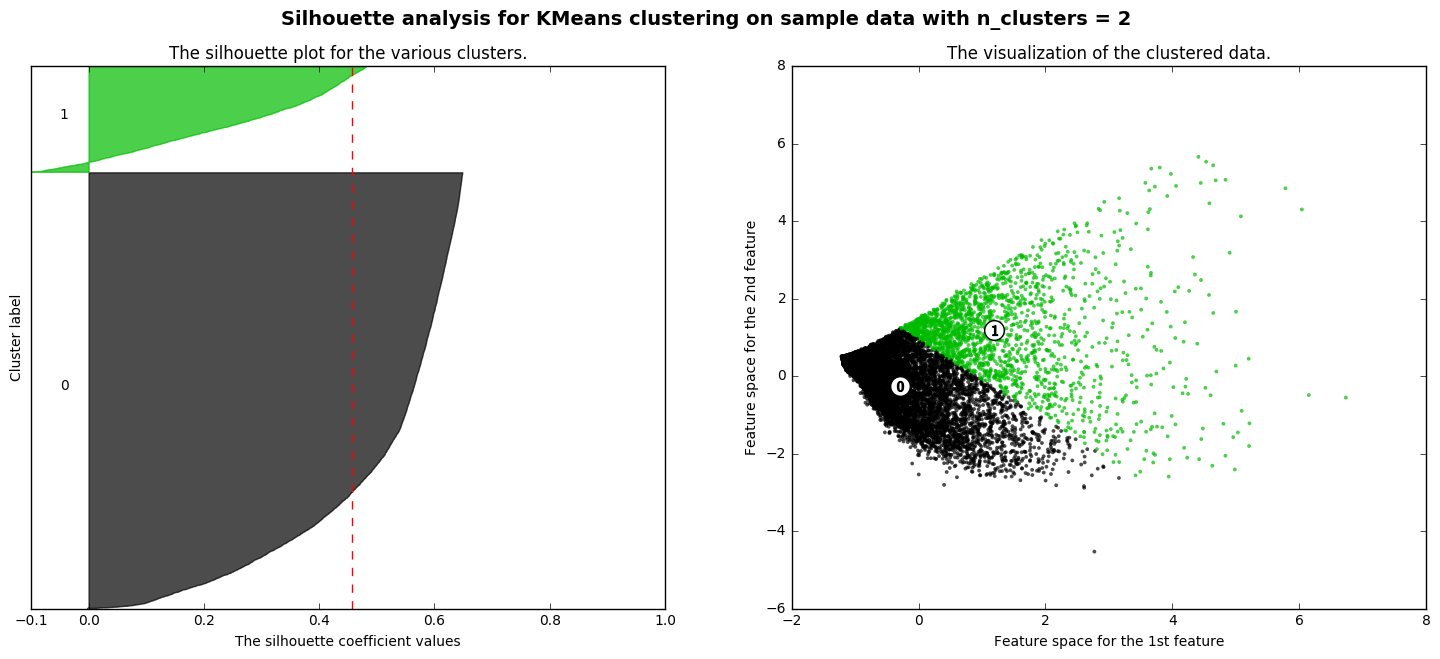

('For n_clusters =', 3, 'The average silhouette_score is :', 0.47970698904855469)


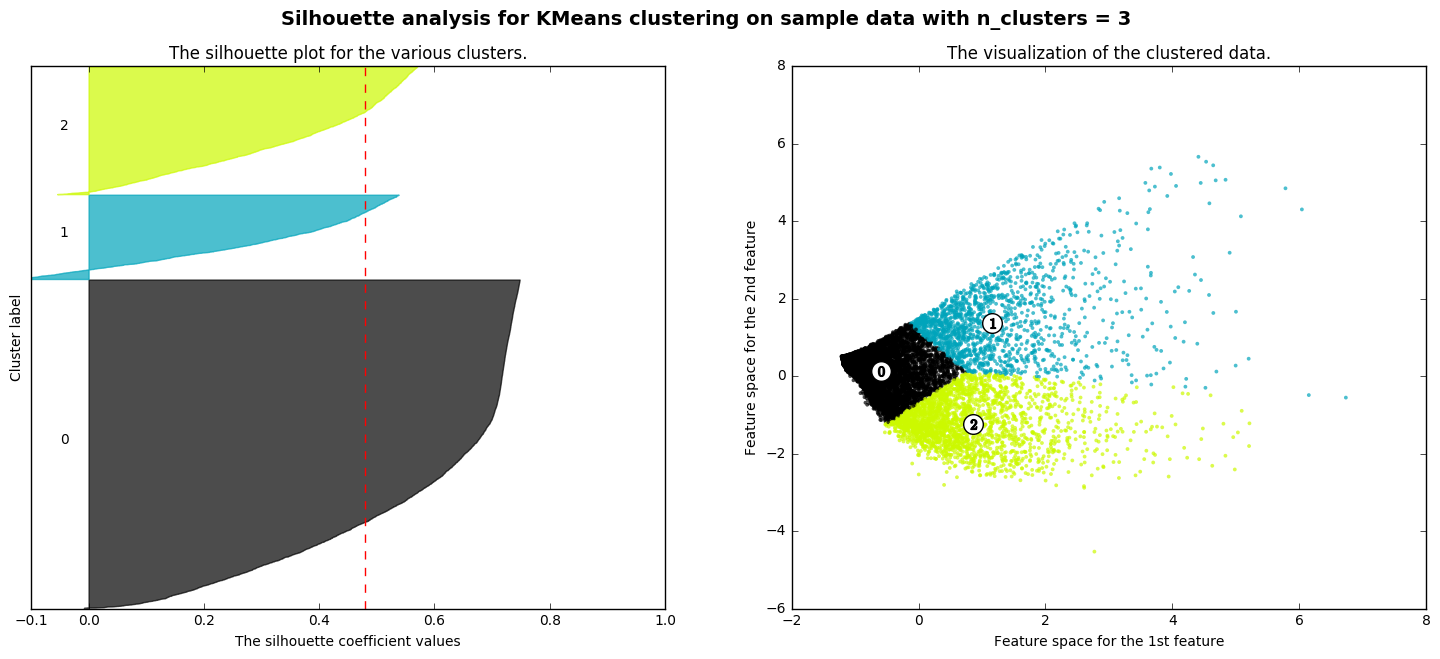

('For n_clusters =', 4, 'The average silhouette_score is :', 0.46432910303852232)


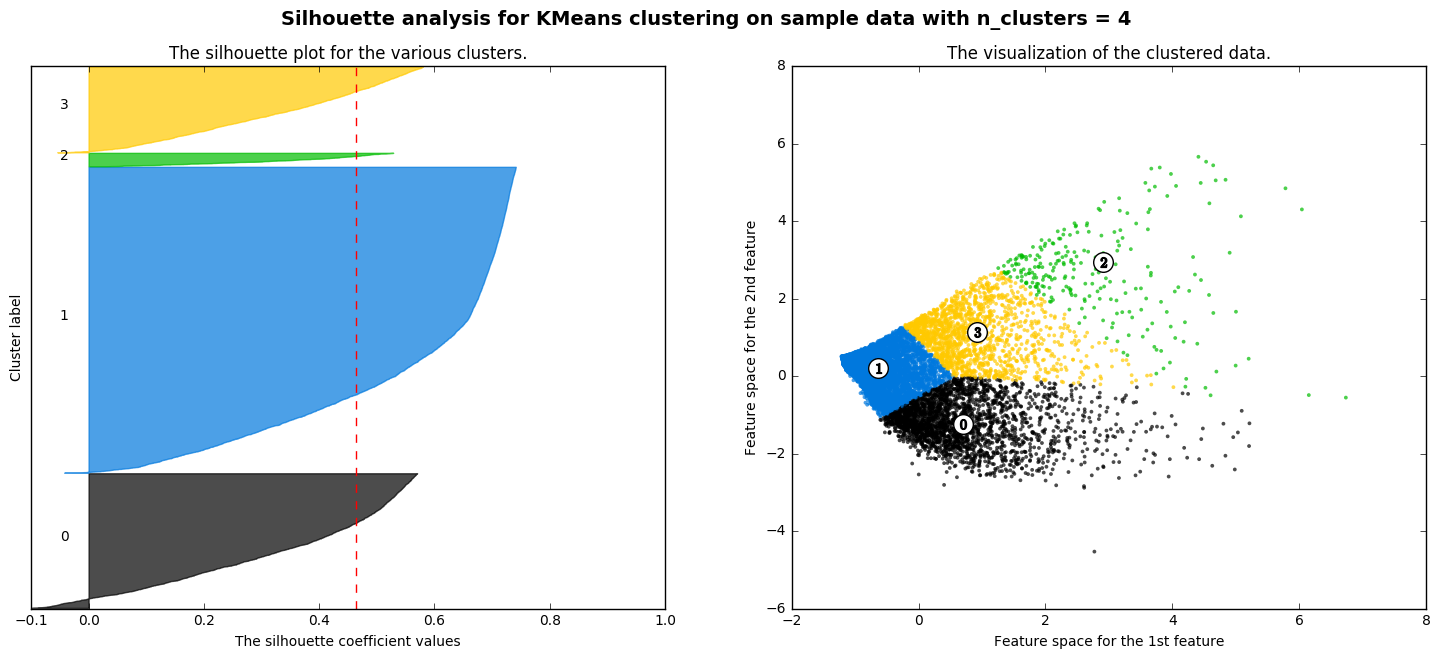

('For n_clusters =', 5, 'The average silhouette_score is :', 0.43947700326783723)


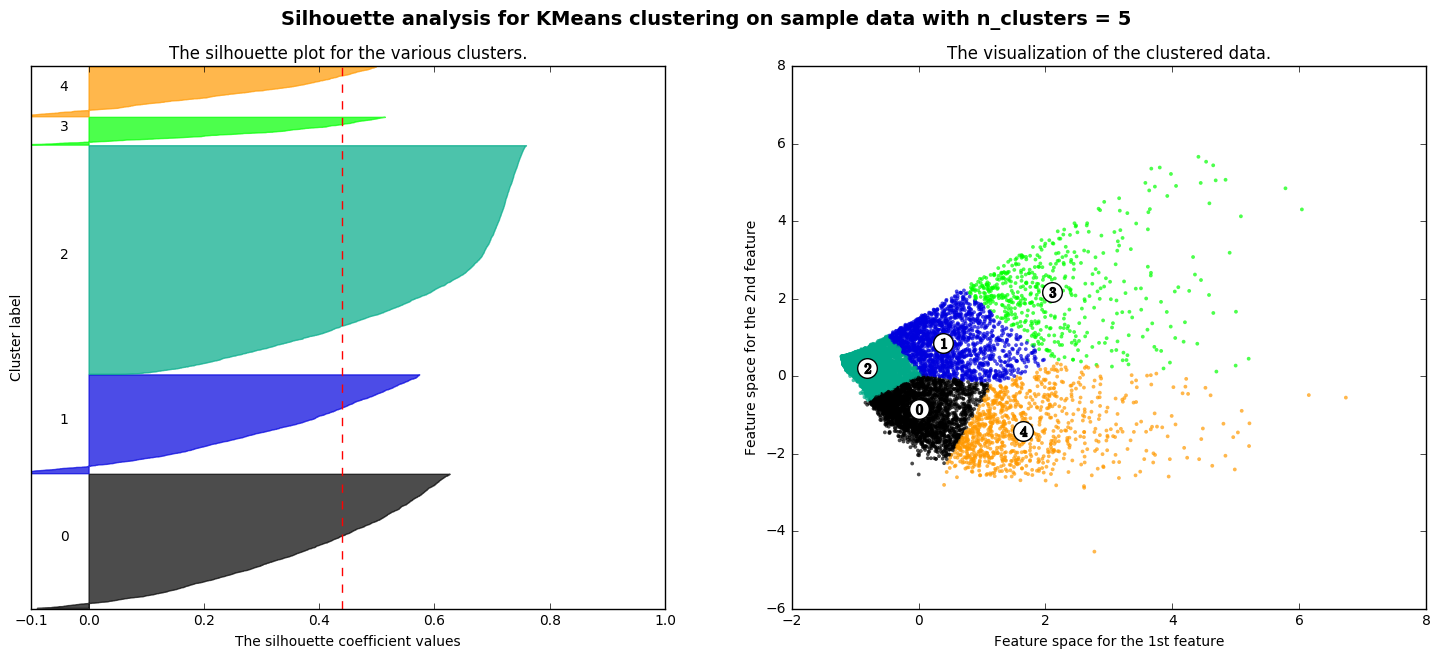

('For n_clusters =', 6, 'The average silhouette_score is :', 0.41716594298961818)


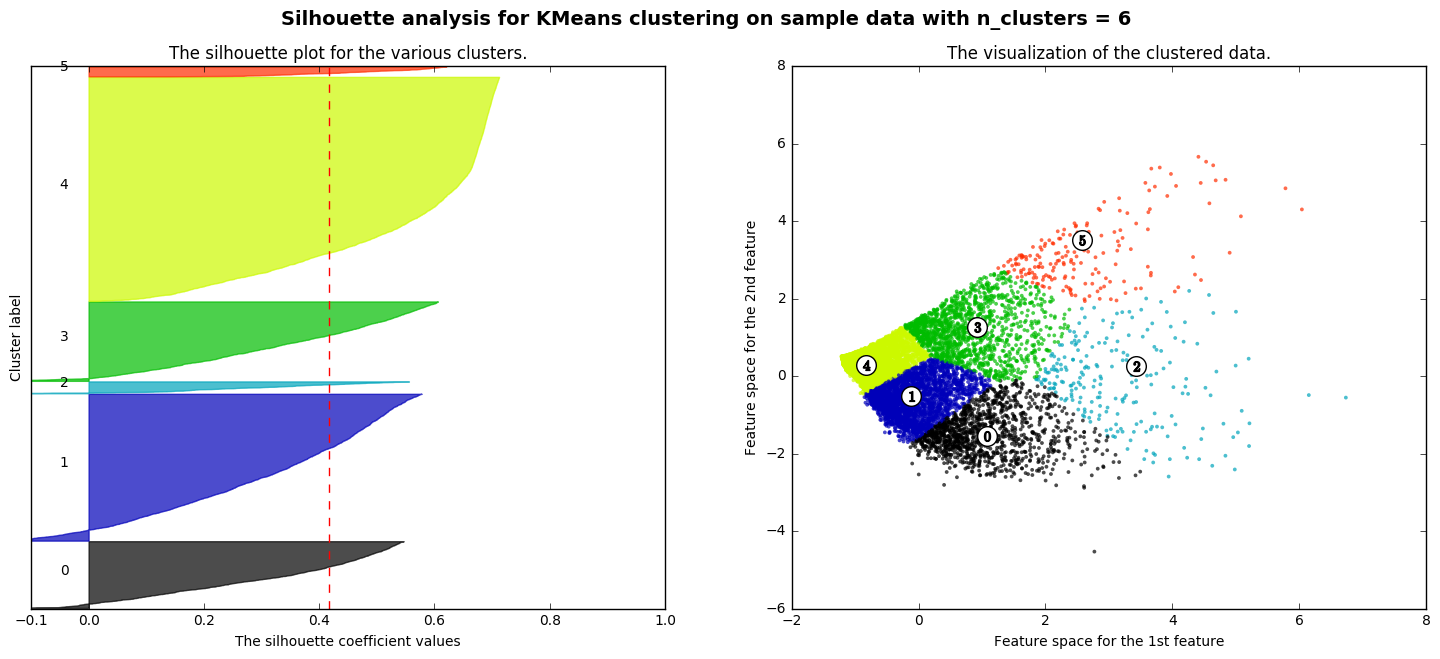

In [41]:
range_n_clusters = range(2, 7)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=45,
                      n_init=10, max_no_improvement=10, verbose=0)

    # clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [42]:
print X[:, 0].mean()
print X[:, 1].mean()

0.000338884425543
0.0213814916682


In [43]:
reducer.explained_variance_ratio_

array([ 0.8393166 ,  0.07699636])